# General


> Training with large-scale datasets can be time-consuming. Therefore, to optimize the model training process and enhance efficiency, we created a smaller mini datasets from the training data. This mini datasets will enable the model to be trained quickly while preserving the fundamental characteristics of the training data.
> 
> In this context, care was taken to select documents with the most labels from the original training dataset. This mini dataset represents the main features of the training data but in a more manageable size. The datasets were created at 10%, 50%, 70% and 40% respectively.
> 
> Subsequently, a validation dataset consisting of documents not found in the mini dataset was created as much as possible. This validation dataset is used to evaluate the model's generalization ability. Thus, it becomes possible to accurately assess the model's performance on real-world data and detect potential overfitting issues. This process aids in optimizing the model training process and gaining a better understanding of how the model performs in real-world scenarios.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pii-detection-removal-from-educational-data/sample_submission.csv
/kaggle/input/pii-detection-removal-from-educational-data/train.json
/kaggle/input/pii-detection-removal-from-educational-data/test.json


In [2]:
import json
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import warnings

# Examining Original Data Set

In [3]:
data = pd.read_csv('/kaggle/input/pii-detection-removal-from-educational-data/sample_submission.csv')
train = json.load(open('/kaggle/input/pii-detection-removal-from-educational-data/train.json'))
test = json.load(open('/kaggle/input/pii-detection-removal-from-educational-data/test.json'))

In [4]:
org_train = pd.DataFrame(train)
org_train.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


In [5]:
org_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6807 entries, 0 to 6806
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   document             6807 non-null   int64 
 1   full_text            6807 non-null   object
 2   tokens               6807 non-null   object
 3   trailing_whitespace  6807 non-null   object
 4   labels               6807 non-null   object
dtypes: int64(1), object(4)
memory usage: 266.0+ KB


In [6]:
# Orijinal train veri setindeki farklı etiketlerin listesi
unique_labels_train = org_train['labels'].explode().unique()

# Orijinal train veri setindeki farklı etiketlerin sayısı
num_unique_labels_train = len(unique_labels_train)

print("Orijinal train veri setindeki farklı etiketlerin sayısı:", num_unique_labels_train)
print("Orijinal train veri setindeki farklı etiketler:")
print(unique_labels_train)


Orijinal train veri setindeki farklı etiketlerin sayısı: 13
Orijinal train veri setindeki farklı etiketler:
['O' 'B-NAME_STUDENT' 'I-NAME_STUDENT' 'B-URL_PERSONAL' 'B-EMAIL'
 'B-ID_NUM' 'I-URL_PERSONAL' 'B-USERNAME' 'B-PHONE_NUM' 'I-PHONE_NUM'
 'B-STREET_ADDRESS' 'I-STREET_ADDRESS' 'I-ID_NUM']


In [7]:
# Her bir etiketi içeren satırları filtreleyelim
labels_to_search = ['O', 'B-NAME_STUDENT', 'I-NAME_STUDENT', 'B-URL_PERSONAL', 'B-ID_NUM', 'B-EMAIL', 
                    'I-STREET_ADDRESS', 'I-PHONE_NUM', 'B-USERNAME', 'B-PHONE_NUM', 'B-STREET_ADDRESS', 
                    'I-URL_PERSONAL', 'I-ID_NUM']

num_documents_with_labels = {}

for label in labels_to_search:
    label_rows = org_train[org_train['labels'].str.contains(label, regex=False)]
    num_documents_with_labels[label] = label_rows['document'].nunique()

for label, num_documents in num_documents_with_labels.items():
    print("Number of documents with", label, ":", num_documents)


Number of documents with O : 6807
Number of documents with B-NAME_STUDENT : 891
Number of documents with I-NAME_STUDENT : 814
Number of documents with B-URL_PERSONAL : 72
Number of documents with B-ID_NUM : 33
Number of documents with B-EMAIL : 24
Number of documents with I-STREET_ADDRESS : 2
Number of documents with I-PHONE_NUM : 3
Number of documents with B-USERNAME : 5
Number of documents with B-PHONE_NUM : 4
Number of documents with B-STREET_ADDRESS : 2
Number of documents with I-URL_PERSONAL : 1
Number of documents with I-ID_NUM : 1


# Creating Mini Data Set (approx.10%)

In [8]:
import pandas as pd

# org_train veri setini yükleyin (dosya yolu doğru belirtilmelidir)
org_train = json.load(open('/kaggle/input/pii-detection-removal-from-educational-data/train.json'))

# org_train veri setini DataFrame'e dönüştürün
org_train_df = pd.DataFrame(org_train)

# Her bir belgenin etiket sayısını hesaplayın
org_train_df['label_count'] = org_train_df['labels'].apply(lambda x: len(x))

# Etiket sayısına göre belgeleri sıralayın ve en çok etiket içeren 500 belgeyi seçin
mini_dataset = org_train_df.nlargest(500, 'label_count')

# Eksik etiketleri bulun
eksik_etiketler = set(['O', 'B-NAME_STUDENT', 'I-NAME_STUDENT', 'B-URL_PERSONAL', 'B-ID_NUM', 'B-EMAIL', 'I-STREET_ADDRESS', 'I-PHONE_NUM', 'B-USERNAME', 'B-PHONE_NUM', 'B-STREET_ADDRESS', 'I-URL_PERSONAL', 'I-ID_NUM']) - set(mini_dataset['labels'].explode().unique())

# Eksik etiketlerden birer tane örnek alarak eksik belgeleri doldurun
for etiket in eksik_etiketler:
    if etiket in org_train_df['labels'].explode().unique():
        belge = org_train_df[org_train_df['labels'].apply(lambda x: etiket in x)].sample(n=1)
        mini_dataset = pd.concat([mini_dataset, belge])

# Sonuçları gösterin
print("Oluşturulan Mini Veri Setinin Boyutu:", mini_dataset.shape)
mini_dataset.head()


Oluşturulan Mini Veri Setinin Boyutu: (505, 6)


,document,full_text,tokens,trailing_whitespace,labels,label_count
2589,12888,Re-Engaging Students: A Learning Launch E...,"[Re, -, Engaging, , Students, :, , A, , Lea...","[False, False, True, False, False, True, False...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",3298
3175,14267,"MIAMISBURG, Ohio, Dec. 10, 2019 /PRNewswire/ -...","[MIAMISBURG, ,, Ohio, ,, Dec., 10, ,, 2019, /P...","[False, True, False, True, True, False, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",3133
6365,21720,"In this assignment, a reflective report will b...","[In, this, assignment, ,, a, reflective, repor...","[True, True, False, True, True, True, True, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",3007
1207,10078,Overcoming Barriers - The Story of the Movie a...,"[Overcoming, Barriers, -, The, Story, of, the,...","[True, True, True, True, True, True, True, Tru...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",2956
781,9188,Design Thinking in Career Development and Coun...,"[Design, Thinking, in, Career, Development, an...","[True, True, True, True, True, True, True, Fal...","[O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-NAM...",2781


In [9]:
mini_dataset.head()


,document,full_text,tokens,trailing_whitespace,labels,label_count
2589,12888,Re-Engaging Students: A Learning Launch E...,"[Re, -, Engaging, , Students, :, , A, , Lea...","[False, False, True, False, False, True, False...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",3298
3175,14267,"MIAMISBURG, Ohio, Dec. 10, 2019 /PRNewswire/ -...","[MIAMISBURG, ,, Ohio, ,, Dec., 10, ,, 2019, /P...","[False, True, False, True, True, False, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",3133
6365,21720,"In this assignment, a reflective report will b...","[In, this, assignment, ,, a, reflective, repor...","[True, True, False, True, True, True, True, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",3007
1207,10078,Overcoming Barriers - The Story of the Movie a...,"[Overcoming, Barriers, -, The, Story, of, the,...","[True, True, True, True, True, True, True, Tru...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",2956
781,9188,Design Thinking in Career Development and Coun...,"[Design, Thinking, in, Career, Development, an...","[True, True, True, True, True, True, True, Fal...","[O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-NAM...",2781


In [10]:
mini_dataset.tail()

,document,full_text,tokens,trailing_whitespace,labels,label_count
5239,19280,Learning Launch based on Design Thinking for I...,"[Learning, Launch, based, on, Design, Thinking...","[True, True, True, True, True, True, True, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",860
103,3202,Final Assignment\n\nUniversity of Virginia's D...,"[Final, Assignment, \n\n, University, of, Virg...","[True, False, False, True, True, False, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",293
114,3351,Example Reflection – Storytelling\n\nChallenge...,"[Example, Reflection, –, Storytelling, \n\n, C...","[True, True, True, False, False, True, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",692
1103,9854,Waseem Mabunda 591 Smith Centers Apt. 656\nJo...,"[Waseem, Mabunda, , 591, Smith, Centers, Apt,...","[True, True, False, True, True, True, False, T...","[B-NAME_STUDENT, I-NAME_STUDENT, O, B-STREET_A...",707
1887,11442,Reflection – Learning Launch of 1861. Milano\n...,"[Reflection, –, Learning, Launch, of, 1861, .,...","[True, True, True, True, True, False, True, Fa...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",1210


In [11]:
mini_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 505 entries, 2589 to 1887
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   document             505 non-null    int64 
 1   full_text            505 non-null    object
 2   tokens               505 non-null    object
 3   trailing_whitespace  505 non-null    object
 4   labels               505 non-null    object
 5   label_count          505 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 27.6+ KB


In [12]:
# Her bir etiket sınıfına ait belge sayılarını hesaplayın
etiket_sayilari = mini_dataset['labels'].explode().value_counts()

# Sonuçları yazdırın
print("Mini Veri Setindeki Her Bir Etiket Sayısı:")
print(etiket_sayilari)


Mini Veri Setindeki Her Bir Etiket Sayısı:
labels
O                   744268
B-NAME_STUDENT         225
I-NAME_STUDENT         186
B-URL_PERSONAL          25
I-STREET_ADDRESS        20
B-EMAIL                  6
B-ID_NUM                 4
I-PHONE_NUM              3
B-PHONE_NUM              2
B-STREET_ADDRESS         2
I-ID_NUM                 1
I-URL_PERSONAL           1
B-USERNAME               1
Name: count, dtype: int64


In [13]:
# Mini veri setinde her bir etiketin bulunduğu belge sayısını hesaplayın
mini_etiket_belge_sayisi = mini_dataset['labels'].explode().value_counts()

# Her bir etiket için en az bir tane bulunan satır sayısını hesaplayın
for etiket in mini_etiket_belge_sayisi.index:
    satir_sayisi = mini_dataset['labels'].apply(lambda x: etiket in x).sum()
    print(f"{etiket}: {satir_sayisi} satır")


O: 505 satır
B-NAME_STUDENT: 121 satır
I-NAME_STUDENT: 119 satır
B-URL_PERSONAL: 15 satır
I-STREET_ADDRESS: 2 satır
B-EMAIL: 4 satır
B-ID_NUM: 3 satır
I-PHONE_NUM: 1 satır
B-PHONE_NUM: 2 satır
B-STREET_ADDRESS: 2 satır
I-ID_NUM: 1 satır
I-URL_PERSONAL: 1 satır
B-USERNAME: 1 satır


In [14]:
mini_dataset = mini_dataset.drop(columns=['label_count'])


In [15]:
mini_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 505 entries, 2589 to 1887
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   document             505 non-null    int64 
 1   full_text            505 non-null    object
 2   tokens               505 non-null    object
 3   trailing_whitespace  505 non-null    object
 4   labels               505 non-null    object
dtypes: int64(1), object(4)
memory usage: 23.7+ KB


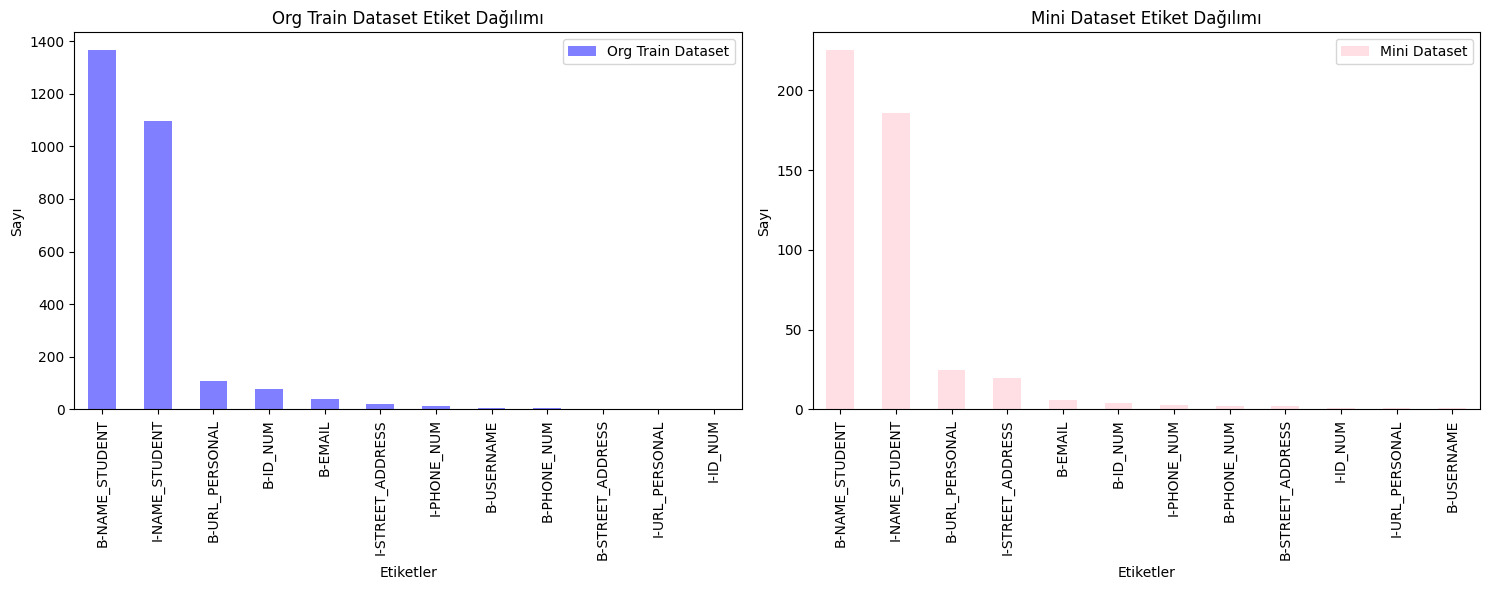

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# org_train veri setini yükleyin (dosya yolu doğru belirtilmelidir)
org_train = json.load(open('/kaggle/input/pii-detection-removal-from-educational-data/train.json'))

# org_train veri setini DataFrame'e dönüştürün
org_train_df = pd.DataFrame(org_train)

# Mini dataset için O etiketi hariç diğer etiketlerin dağılımını hesaplayın
mini_etiketler = mini_dataset['labels'].explode()
mini_etiketler = mini_etiketler[mini_etiketler != 'O']
mini_etiket_dağılımı = mini_etiketler.value_counts()

# org_train veri seti için O etiketi hariç diğer etiketlerin dağılımını hesaplayın
org_etiketler = org_train_df['labels'].explode()
org_etiketler = org_etiketler[org_etiketler != 'O']
org_etiket_dağılımı = org_etiketler.value_counts()

# Grafikleri oluşturun
plt.figure(figsize=(15, 6))

# Sütun grafik oluşturun
plt.subplot(1, 2, 1)
org_etiket_dağılımı.plot(kind='bar', color='blue', alpha=0.5, label='Org Train Dataset')
plt.title('Org Train Dataset Etiket Dağılımı')
plt.xlabel('Etiketler')
plt.ylabel('Sayı')
plt.legend()

# Sütun grafik oluşturun
plt.subplot(1, 2, 2)
mini_etiket_dağılımı.plot(kind='bar', color='pink', alpha=0.5, label='Mini Dataset')
plt.title('Mini Dataset Etiket Dağılımı')
plt.xlabel('Etiketler')
plt.ylabel('Sayı')
plt.legend()

# Grafikleri gösterin
plt.tight_layout()
plt.show()


/tmp/ipykernel_18/2180492386.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, org_etiket_dağılımı[i] + 0.5, f"{org_etiket_dağılımı[i]:.2f}%", ha='center', va='bottom')
/tmp/ipykernel_18/2180492386.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, mini_etiket_dağılımı[i] + 0.5, f"{mini_etiket_dağılımı[i]:.2f}%", ha='center', va='bottom')


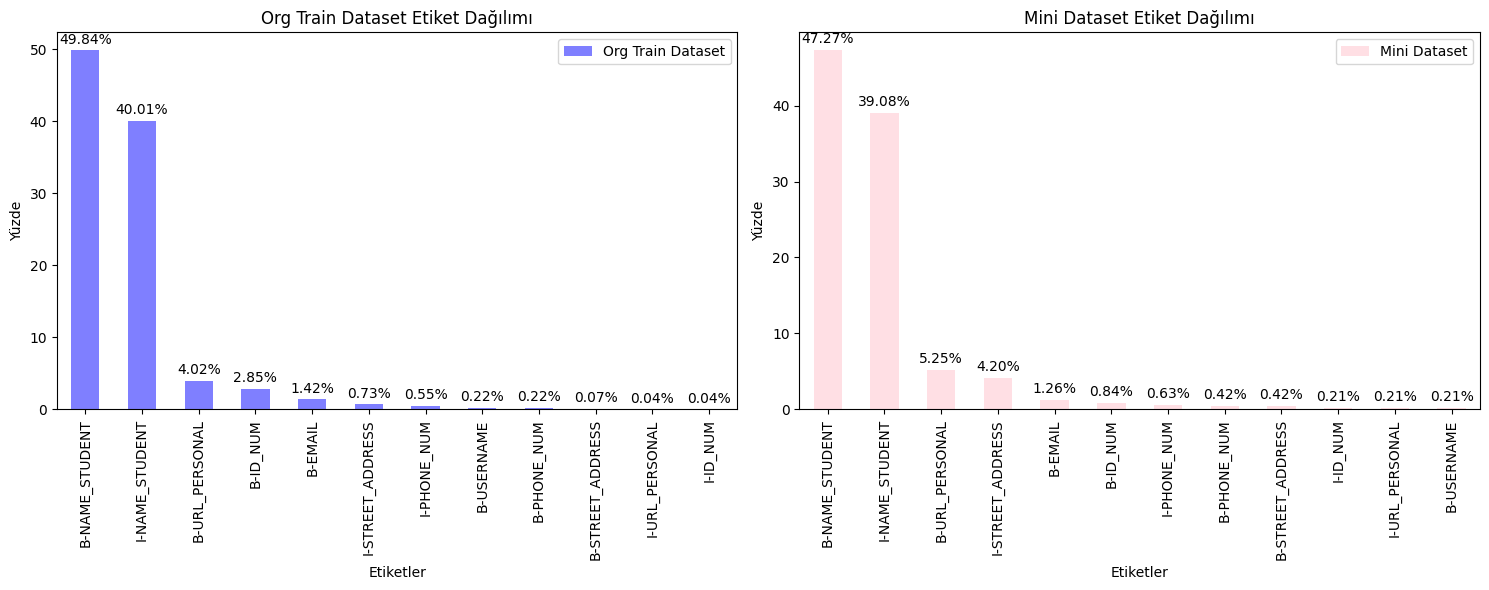

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# org_train veri setini yükleyin (dosya yolu doğru belirtilmelidir)
org_train = json.load(open('/kaggle/input/pii-detection-removal-from-educational-data/train.json'))

# org_train veri setini DataFrame'e dönüştürün
org_train_df = pd.DataFrame(org_train)

# Mini dataset için O etiketi hariç diğer etiketlerin dağılımını hesaplayın
mini_etiketler = mini_dataset['labels'].explode()
mini_etiketler = mini_etiketler[mini_etiketler != 'O']
mini_etiket_dağılımı = mini_etiketler.value_counts(normalize=True) * 100

# org_train veri seti için O etiketi hariç diğer etiketlerin dağılımını hesaplayın
org_etiketler = org_train_df['labels'].explode()
org_etiketler = org_etiketler[org_etiketler != 'O']
org_etiket_dağılımı = org_etiketler.value_counts(normalize=True) * 100

# Grafikleri oluşturun
plt.figure(figsize=(15, 6))

# Sütun grafik oluşturun
plt.subplot(1, 2, 1)
org_etiket_dağılımı.plot(kind='bar', color='blue', alpha=0.5, label='Org Train Dataset')
for i in range(len(org_etiket_dağılımı)):
    plt.text(i, org_etiket_dağılımı[i] + 0.5, f"{org_etiket_dağılımı[i]:.2f}%", ha='center', va='bottom')
plt.title('Org Train Dataset Etiket Dağılımı')
plt.xlabel('Etiketler')
plt.ylabel('Yüzde')
plt.legend()

# Sütun grafik oluşturun
plt.subplot(1, 2, 2)
mini_etiket_dağılımı.plot(kind='bar', color='pink', alpha=0.5, label='Mini Dataset')
for i in range(len(mini_etiket_dağılımı)):
    plt.text(i, mini_etiket_dağılımı[i] + 0.5, f"{mini_etiket_dağılımı[i]:.2f}%", ha='center', va='bottom')
plt.title('Mini Dataset Etiket Dağılımı')
plt.xlabel('Etiketler')
plt.ylabel('Yüzde')
plt.legend()

# Grafikleri gösterin
plt.tight_layout()
plt.show()


In [18]:
df = pd.DataFrame(mini_dataset)

df.to_json('train_10p.json', orient='records')

In [19]:
df = pd.DataFrame(mini_dataset)

df.to_csv('MiniDSv1.csv', index=False)


# Creating Validation Data Set

In [20]:

# org_train veri setini DataFrame'e dönüştürün
org_train_df = pd.DataFrame(org_train)

# Her bir belgenin etiket sayısını hesaplayın
org_train_df['label_count'] = org_train_df['labels'].apply(len)

# Etiket sayısına göre belgeleri sıralayın
org_train_df = org_train_df.sort_values(by='label_count', ascending=False)

# En çok etiket içeren ikinci 502-1007 belgeyi seçin
validation_data = org_train_df.iloc[502:1007]

# Eksik etiketleri bulun
eksik_etiketler = set(['O', 'B-NAME_STUDENT', 'I-NAME_STUDENT', 'B-URL_PERSONAL', 'B-ID_NUM', 'B-EMAIL', 'I-STREET_ADDRESS', 'I-PHONE_NUM', 'B-USERNAME', 'B-PHONE_NUM', 'B-STREET_ADDRESS', 'I-URL_PERSONAL', 'I-ID_NUM']) - set(validation_data['labels'].explode().unique())

# Eksik etiketlerden birer tane örnek alarak eksik belgeleri doldurun
for etiket in eksik_etiketler:
    if etiket in org_train_df['labels'].explode().unique():
        belge = org_train_df[org_train_df['labels'].apply(lambda x: etiket in x)].sample(n=1)
        validation_data = pd.concat([validation_data, belge])

# Veri kümesini belirli bir boyuta indir
desired_size = 505
if len(validation_data) > desired_size:
    validation_data = validation_data.sample(n=desired_size)
 
# Sonuçları gösterin
print("Size of Validation Data Set Created:", validation_data.shape)
validation_data.head()


Size of Validation Data Set Created: (505, 6)


,document,full_text,tokens,trailing_whitespace,labels,label_count
2279,12254,Levels of Learning through Learning Launch\n\n...,"[Levels, of, Learning, through, Learning, Laun...","[True, True, True, True, True, False, False, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",1141
5951,20872,Storytelling\n\nChallenge and Selection Sto...,"[Storytelling, \n\n, Challenge, and, Selection...","[False, False, True, True, True, False, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",1197
5770,20446,Example Reflection – Mind Mapping\n\nChallenge...,"[Example, Reflection, –, Mind, Mapping, \n\n, ...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",1208
3229,14412,"Challenge & Selection\n\nOne of our clients, a...","[Challenge, &, Selection, \n\n, One, of, our, ...","[True, True, False, False, True, True, True, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",1101
2155,11988,Storytelling-Reduction of overtime of BCWs at ...,"[Storytelling, -, Reduction, of, overtime, of,...","[False, False, True, True, True, True, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",1071


In [21]:
validation_data = validation_data.drop(columns=['label_count'])


In [22]:
validation_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 505 entries, 2279 to 2554
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   document             505 non-null    int64 
 1   full_text            505 non-null    object
 2   tokens               505 non-null    object
 3   trailing_whitespace  505 non-null    object
 4   labels               505 non-null    object
dtypes: int64(1), object(4)
memory usage: 23.7+ KB


In [23]:
document_count = validation_data['labels'].explode().value_counts()

# Her bir etiket için en az bir tane bulunan satır sayısını hesaplayın
for etiket in document_count.index:
    satir_sayisi = validation_data['labels'].apply(lambda x: etiket in x).sum()
    print(f"{etiket}: {satir_sayisi} row")


O: 505 row
B-NAME_STUDENT: 109 row
I-NAME_STUDENT: 97 row
B-URL_PERSONAL: 12 row
I-STREET_ADDRESS: 1 row
B-ID_NUM: 2 row
I-PHONE_NUM: 1 row
B-EMAIL: 3 row
B-PHONE_NUM: 1 row
I-ID_NUM: 1 row
B-USERNAME: 1 row
B-STREET_ADDRESS: 1 row
I-URL_PERSONAL: 1 row


In [24]:
# Extract document IDs from the mini dataset and validation dataset
mini_doc_ids = set(mini_dataset['document'])
validation_doc_ids = set(validation_data['document'])

# Find the common document IDs between both datasets
common_doc_ids = mini_doc_ids.intersection(validation_doc_ids)

# Find the number of common document IDs
num_common_docs = len(common_doc_ids)

# Print the result
print("There are", num_common_docs, "common document IDs in both datasets.")


There are 4 common document IDs in both datasets.


/tmp/ipykernel_18/660071937.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(label_counts.index, rotation='vertical')  # Rotate x-axis labels vertically
/tmp/ipykernel_18/660071937.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(label_counts.index, rotation='vertical')  # Rotate x-axis labels vertically


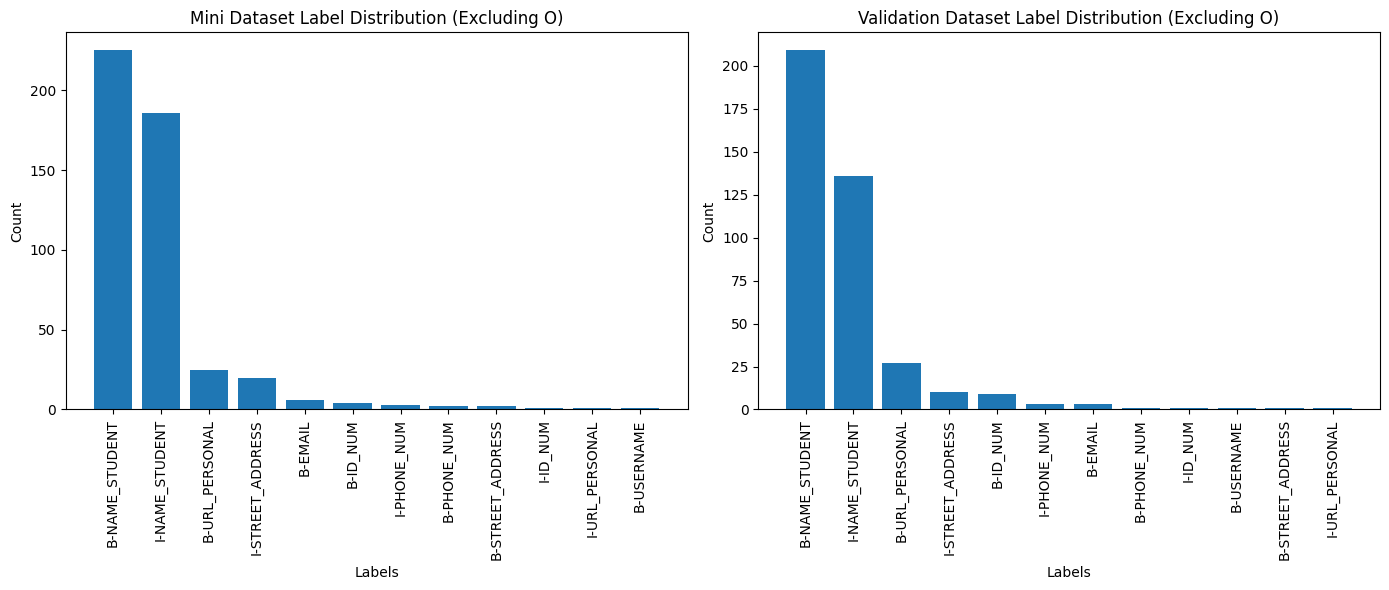

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot label distribution excluding 'O' label
def plot_label_distribution_excluding_O(data, title, ax):
    label_counts = data['labels'].explode().value_counts().drop('O')
    ax.bar(label_counts.index, label_counts.values)
    ax.set_title(title)
    ax.set_xlabel('Labels')
    ax.set_ylabel('Count')
    ax.set_xticklabels(label_counts.index, rotation='vertical')  # Rotate x-axis labels vertically

# Create a figure and axes objects
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot label distribution for mini dataset excluding 'O' label
plot_label_distribution_excluding_O(mini_dataset, 'Mini Dataset Label Distribution (Excluding O)', axs[0])

# Plot label distribution for validation dataset excluding 'O' label
plot_label_distribution_excluding_O(validation_data, 'Validation Dataset Label Distribution (Excluding O)', axs[1])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [26]:
validation_data.to_json("val.json", orient="records", lines=True)


# Creating Mini Data Set 2 (approx.50%)

In [27]:

org_train = json.load(open('/kaggle/input/pii-detection-removal-from-educational-data/train.json'))

org_train_df = pd.DataFrame(org_train)

org_train_df['label_count'] = org_train_df['labels'].apply(lambda x: len(x))

mini_dataset2 = org_train_df.nlargest(3403, 'label_count')

missing_labels = set(['O', 'B-NAME_STUDENT', 'I-NAME_STUDENT', 'B-URL_PERSONAL', 'B-ID_NUM', 'B-EMAIL', 'I-STREET_ADDRESS', 'I-PHONE_NUM', 'B-USERNAME', 'B-PHONE_NUM', 'B-STREET_ADDRESS', 'I-URL_PERSONAL', 'I-ID_NUM']) - set(mini_dataset2['labels'].explode().unique())

for label in missing_labels:
    if label in org_train_df['labels'].explode().unique():
        document = org_train_df[org_train_df['labels'].apply(lambda x: label in x)].sample(n=1)
        mini_dataset2 = pd.concat([mini_dataset2, document])

mini_dataset2 = mini_dataset2.drop(columns=['label_count'])
mini_dataset2.to_json('train_50p.json', orient='records')

# Sonuçları gösterin
print("Oluşturulan Mini Veri Setinin Boyutu:", mini_dataset2.shape)
mini_dataset2.head()


Oluşturulan Mini Veri Setinin Boyutu: (3404, 5)


,document,full_text,tokens,trailing_whitespace,labels
2589,12888,Re-Engaging Students: A Learning Launch E...,"[Re, -, Engaging, , Students, :, , A, , Lea...","[False, False, True, False, False, True, False...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3175,14267,"MIAMISBURG, Ohio, Dec. 10, 2019 /PRNewswire/ -...","[MIAMISBURG, ,, Ohio, ,, Dec., 10, ,, 2019, /P...","[False, True, False, True, True, False, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6365,21720,"In this assignment, a reflective report will b...","[In, this, assignment, ,, a, reflective, repor...","[True, True, False, True, True, True, True, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1207,10078,Overcoming Barriers - The Story of the Movie a...,"[Overcoming, Barriers, -, The, Story, of, the,...","[True, True, True, True, True, True, True, Tru...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
781,9188,Design Thinking in Career Development and Coun...,"[Design, Thinking, in, Career, Development, an...","[True, True, True, True, True, True, True, Fal...","[O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-NAM..."


In [28]:
mini_dataset2.tail()

,document,full_text,tokens,trailing_whitespace,labels
4166,16688,Challenge\n\nI work in the business intelligen...,"[Challenge, \n\n, I, work, in, the, business, ...","[False, False, True, True, True, True, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4223,16848,Reflection - Mind Mapping\n\nChallenge\n\nI'm ...,"[Reflection, -, Mind, Mapping, \n\n, Challenge...","[True, True, True, False, False, False, False,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4288,17006,Example Reflection – Mind Mapping\n\nChallenge...,"[Example, Reflection, –, Mind, Mapping, \n\n, ...","[True, True, True, True, False, False, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4986,18685,"Assignment, Design thinking for innovation\n\n...","[Assignment, ,, Design, thinking, for, innovat...","[False, True, True, True, True, False, False, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
103,3202,Final Assignment\n\nUniversity of Virginia's D...,"[Final, Assignment, \n\n, University, of, Virg...","[True, False, False, True, True, False, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [29]:
mini_dataset2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3404 entries, 2589 to 103
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   document             3404 non-null   int64 
 1   full_text            3404 non-null   object
 2   tokens               3404 non-null   object
 3   trailing_whitespace  3404 non-null   object
 4   labels               3404 non-null   object
dtypes: int64(1), object(4)
memory usage: 288.6+ KB


In [30]:
etiket_sayilari = mini_dataset2['labels'].explode().value_counts()

# Sonuçları yazdırın
print("Number of Each Label:")
print(etiket_sayilari)


Number of Each Label:
labels
O                   3298416
B-NAME_STUDENT          911
I-NAME_STUDENT          749
B-URL_PERSONAL           85
B-EMAIL                  31
B-ID_NUM                 27
I-STREET_ADDRESS         20
I-PHONE_NUM              12
B-PHONE_NUM               5
B-USERNAME                3
B-STREET_ADDRESS          2
I-ID_NUM                  1
I-URL_PERSONAL            1
Name: count, dtype: int64


In [31]:
# Mini veri setinde her bir etiketin bulunduğu belge sayısını hesaplayın
mini_etiket_belge_sayisi = mini_dataset2['labels'].explode().value_counts()

# Her bir etiket için en az bir tane bulunan satır sayısını hesaplayın
for etiket in mini_etiket_belge_sayisi.index:
    satir_sayisi = mini_dataset2['labels'].apply(lambda x: etiket in x).sum()
    print(f"{etiket}: {satir_sayisi} satır")


O: 3404 satır
B-NAME_STUDENT: 567 satır
I-NAME_STUDENT: 532 satır
B-URL_PERSONAL: 52 satır
B-EMAIL: 17 satır
B-ID_NUM: 9 satır
I-STREET_ADDRESS: 2 satır
I-PHONE_NUM: 2 satır
B-PHONE_NUM: 3 satır
B-USERNAME: 2 satır
B-STREET_ADDRESS: 2 satır
I-ID_NUM: 1 satır
I-URL_PERSONAL: 1 satır


/tmp/ipykernel_18/722790160.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, org_label_distribution[i] + 0.5, f"{org_label_distribution[i]:.2f}%", ha='center', va='bottom')
/tmp/ipykernel_18/722790160.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, mini_label_distribution[i] + 0.5, f"{mini_label_distribution[i]:.2f}%", ha='center', va='bottom')


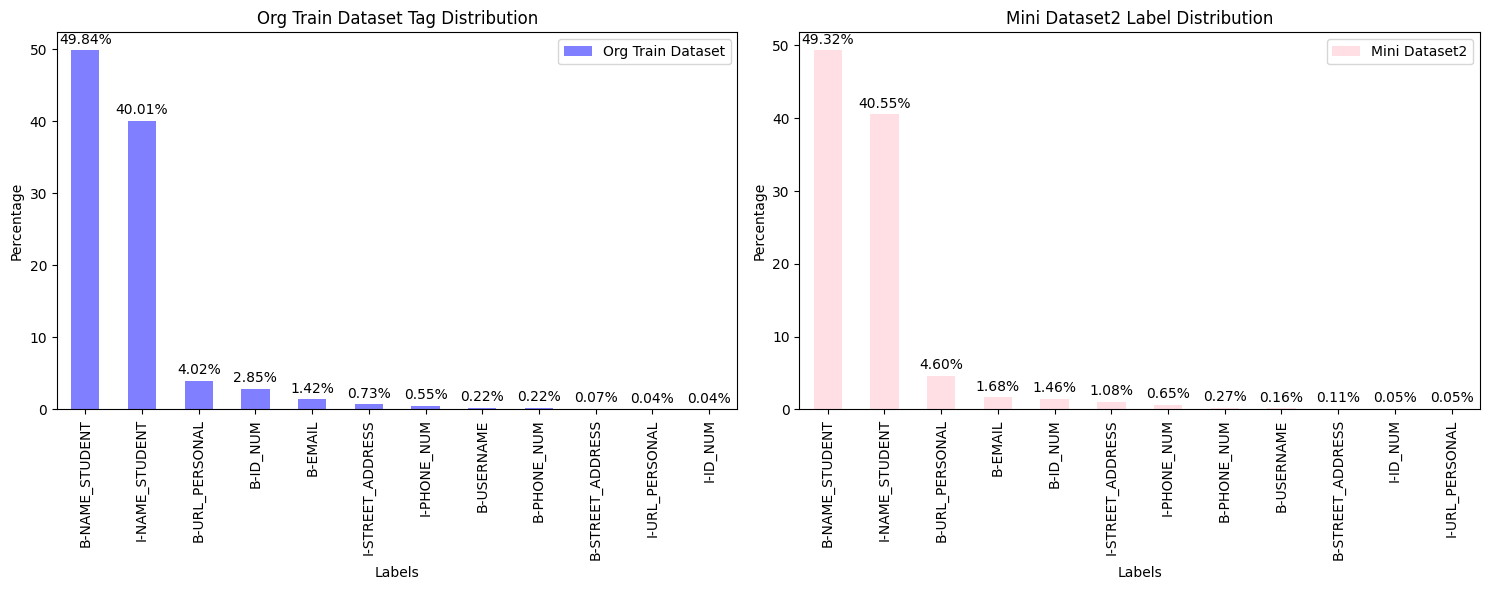

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# org_train veri setini yükleyin (dosya yolu doğru belirtilmelidir)
org_train = json.load(open('/kaggle/input/pii-detection-removal-from-educational-data/train.json'))

# org_train veri setini DataFrame'e dönüştürün
org_train_df = pd.DataFrame(org_train)

# Mini dataset için O etiketi hariç diğer etiketlerin dağılımını hesaplayın
mini_labels = mini_dataset2['labels'].explode()
mini_labels = mini_labels[mini_labels != 'O']
mini_label_distribution = mini_labels.value_counts(normalize=True) * 100

# org_train veri seti için O etiketi hariç diğer etiketlerin dağılımını hesaplayın
org_labels = org_train_df['labels'].explode()
org_labels = org_labels[org_labels != 'O']
org_label_distribution = org_labels.value_counts(normalize=True) * 100

# Grafikleri oluşturun
plt.figure(figsize=(15, 6))

# Sütun grafik oluşturun
plt.subplot(1, 2, 1)
org_label_distribution.plot(kind='bar', color='blue', alpha=0.5, label='Org Train Dataset')
for i in range(len(org_label_distribution)):
    plt.text(i, org_label_distribution[i] + 0.5, f"{org_label_distribution[i]:.2f}%", ha='center', va='bottom')
plt.title('Org Train Dataset Tag Distribution')
plt.xlabel('Labels')
plt.ylabel('Percentage')
plt.legend()

# Sütun grafik oluşturun
plt.subplot(1, 2, 2)
mini_label_distribution.plot(kind='bar', color='pink', alpha=0.5, label='Mini Dataset2')
for i in range(len(mini_label_distribution)):
    plt.text(i, mini_label_distribution[i] + 0.5, f"{mini_label_distribution[i]:.2f}%", ha='center', va='bottom')
plt.title('Mini Dataset2 Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Percentage')
plt.legend()

# Grafikleri gösterin
plt.tight_layout()
plt.show()


# Creating Mini Data Set 3 (approx.70%)

In [33]:
org_train = json.load(open('/kaggle/input/pii-detection-removal-from-educational-data/train.json'))

org_train_df = pd.DataFrame(org_train)

org_train_df['label_count'] = org_train_df['labels'].apply(lambda x: len(x))

mini_dataset3 = org_train_df.nlargest(4764, 'label_count')

missing_labels = set(['O', 'B-NAME_STUDENT', 'I-NAME_STUDENT', 'B-URL_PERSONAL', 'B-ID_NUM', 'B-EMAIL', 'I-STREET_ADDRESS', 'I-PHONE_NUM', 'B-USERNAME', 'B-PHONE_NUM', 'B-STREET_ADDRESS', 'I-URL_PERSONAL', 'I-ID_NUM']) - set(mini_dataset3['labels'].explode().unique())

for label in missing_labels:
    if label in org_train_df['labels'].explode().unique():
        document = org_train_df[org_train_df['labels'].apply(lambda x: label in x)].sample(n=1)
        mini_dataset3 = pd.concat([mini_dataset3, document])

mini_dataset3 = mini_dataset3.drop(columns=['label_count'])
mini_dataset3.to_json('train_70p.json', orient='records')

# Sonuçları gösterin
print("Oluşturulan Mini Veri Setinin Boyutu:", mini_dataset3.shape)
mini_dataset3.head()


Oluşturulan Mini Veri Setinin Boyutu: (4765, 5)


,document,full_text,tokens,trailing_whitespace,labels
2589,12888,Re-Engaging Students: A Learning Launch E...,"[Re, -, Engaging, , Students, :, , A, , Lea...","[False, False, True, False, False, True, False...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3175,14267,"MIAMISBURG, Ohio, Dec. 10, 2019 /PRNewswire/ -...","[MIAMISBURG, ,, Ohio, ,, Dec., 10, ,, 2019, /P...","[False, True, False, True, True, False, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6365,21720,"In this assignment, a reflective report will b...","[In, this, assignment, ,, a, reflective, repor...","[True, True, False, True, True, True, True, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1207,10078,Overcoming Barriers - The Story of the Movie a...,"[Overcoming, Barriers, -, The, Story, of, the,...","[True, True, True, True, True, True, True, Tru...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
781,9188,Design Thinking in Career Development and Coun...,"[Design, Thinking, in, Career, Development, an...","[True, True, True, True, True, True, True, Fal...","[O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-NAM..."


In [34]:
mini_dataset3.tail()

,document,full_text,tokens,trailing_whitespace,labels
2986,13801,Example Reflection – Storytelling\n\nChallenge...,"[Example, Reflection, –, Storytelling, \n\n, C...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3485,15000,Use of disposable cups in the office and visua...,"[Use, of, disposable, cups, in, the, office, a...","[True, True, True, True, True, True, True, Tru...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4599,17748,Assignment\n\nDesign Thinking Tool – Visualiza...,"[Assignment, \n\n, Design, Thinking, Tool, –, ...","[False, False, True, True, True, True, False, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4627,17817,STORYTELLING\n\nChallenge\n\nIn todays’ corpor...,"[STORYTELLING, \n\n, Challenge, \n\n, In, toda...","[False, False, False, False, True, False, True...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
103,3202,Final Assignment\n\nUniversity of Virginia's D...,"[Final, Assignment, \n\n, University, of, Virg...","[True, False, False, True, True, False, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [35]:
mini_dataset3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4765 entries, 2589 to 103
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   document             4765 non-null   int64 
 1   full_text            4765 non-null   object
 2   tokens               4765 non-null   object
 3   trailing_whitespace  4765 non-null   object
 4   labels               4765 non-null   object
dtypes: int64(1), object(4)
memory usage: 352.4+ KB


In [36]:
etiket_sayilari = mini_dataset3['labels'].explode().value_counts()

# Sonuçları yazdırın
print("Number of Each Label:")
print(etiket_sayilari)


Number of Each Label:
labels
O                   4147468
B-NAME_STUDENT         1107
I-NAME_STUDENT          896
B-URL_PERSONAL           93
B-ID_NUM                 42
B-EMAIL                  33
I-STREET_ADDRESS         20
I-PHONE_NUM              12
B-PHONE_NUM               5
B-USERNAME                5
B-STREET_ADDRESS          2
I-ID_NUM                  1
I-URL_PERSONAL            1
Name: count, dtype: int64


In [37]:
# Mini veri setinde her bir etiketin bulunduğu belge sayısını hesaplayın
mini_etiket_belge_sayisi = mini_dataset3['labels'].explode().value_counts()

# Her bir etiket için en az bir tane bulunan satır sayısını hesaplayın
for etiket in mini_etiket_belge_sayisi.index:
    satir_sayisi = mini_dataset3['labels'].apply(lambda x: etiket in x).sum()
    print(f"{etiket}: {satir_sayisi} satır")


O: 4765 satır
B-NAME_STUDENT: 702 satır
I-NAME_STUDENT: 651 satır
B-URL_PERSONAL: 59 satır
B-ID_NUM: 16 satır
B-EMAIL: 19 satır
I-STREET_ADDRESS: 2 satır
I-PHONE_NUM: 2 satır
B-PHONE_NUM: 3 satır
B-USERNAME: 4 satır
B-STREET_ADDRESS: 2 satır
I-ID_NUM: 1 satır
I-URL_PERSONAL: 1 satır


/tmp/ipykernel_18/3855826255.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, org_label_distribution[i] + 0.5, f"{org_label_distribution[i]:.2f}%", ha='center', va='bottom')
/tmp/ipykernel_18/3855826255.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, mini_label_distribution[i] + 0.5, f"{mini_label_distribution[i]:.2f}%", ha='center', va='bottom')


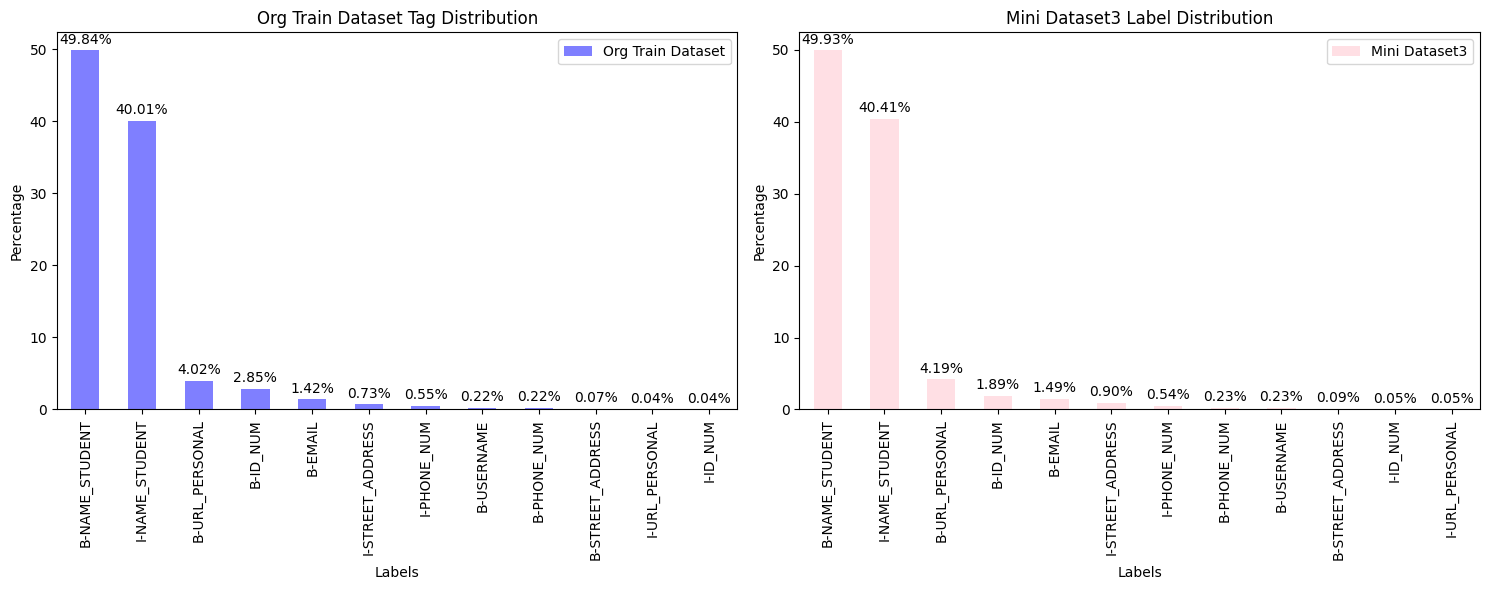

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# org_train veri setini yükleyin (dosya yolu doğru belirtilmelidir)
org_train = json.load(open('/kaggle/input/pii-detection-removal-from-educational-data/train.json'))

# org_train veri setini DataFrame'e dönüştürün
org_train_df = pd.DataFrame(org_train)

# Mini dataset için O etiketi hariç diğer etiketlerin dağılımını hesaplayın
mini_labels = mini_dataset3['labels'].explode()
mini_labels = mini_labels[mini_labels != 'O']
mini_label_distribution = mini_labels.value_counts(normalize=True) * 100

# org_train veri seti için O etiketi hariç diğer etiketlerin dağılımını hesaplayın
org_labels = org_train_df['labels'].explode()
org_labels = org_labels[org_labels != 'O']
org_label_distribution = org_labels.value_counts(normalize=True) * 100

# Grafikleri oluşturun
plt.figure(figsize=(15, 6))

# Sütun grafik oluşturun
plt.subplot(1, 2, 1)
org_label_distribution.plot(kind='bar', color='blue', alpha=0.5, label='Org Train Dataset')
for i in range(len(org_label_distribution)):
    plt.text(i, org_label_distribution[i] + 0.5, f"{org_label_distribution[i]:.2f}%", ha='center', va='bottom')
plt.title('Org Train Dataset Tag Distribution')
plt.xlabel('Labels')
plt.ylabel('Percentage')
plt.legend()

# Sütun grafik oluşturun
plt.subplot(1, 2, 2)
mini_label_distribution.plot(kind='bar', color='pink', alpha=0.5, label='Mini Dataset3')
for i in range(len(mini_label_distribution)):
    plt.text(i, mini_label_distribution[i] + 0.5, f"{mini_label_distribution[i]:.2f}%", ha='center', va='bottom')
plt.title('Mini Dataset3 Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Percentage')
plt.legend()

# Grafikleri gösterin
plt.tight_layout()
plt.show()


# Creating Mini Data Set (approx.40%)

In [39]:
org_train = json.load(open('/kaggle/input/pii-detection-removal-from-educational-data/train.json'))

org_train_df = pd.DataFrame(org_train)

org_train_df['label_count'] = org_train_df['labels'].apply(lambda x: len(x))

mini_dataset4 = org_train_df.nlargest(2723, 'label_count')

missing_labels = set(['O', 'B-NAME_STUDENT', 'I-NAME_STUDENT', 'B-URL_PERSONAL', 'B-ID_NUM', 'B-EMAIL', 'I-STREET_ADDRESS', 'I-PHONE_NUM', 'B-USERNAME', 'B-PHONE_NUM', 'B-STREET_ADDRESS', 'I-URL_PERSONAL', 'I-ID_NUM']) - set(mini_dataset4['labels'].explode().unique())

for label in missing_labels:
    if label in org_train_df['labels'].explode().unique():
        document = org_train_df[org_train_df['labels'].apply(lambda x: label in x)].sample(n=1)
        mini_dataset4 = pd.concat([mini_dataset4, document])

mini_dataset4 = mini_dataset4.drop(columns=['label_count'])
mini_dataset4.to_json('train_40p.json', orient='records')

# Sonuçları gösterin
print("Oluşturulan Mini Veri Setinin Boyutu:", mini_dataset4.shape)
mini_dataset4.head()


Oluşturulan Mini Veri Setinin Boyutu: (2724, 5)


,document,full_text,tokens,trailing_whitespace,labels
2589,12888,Re-Engaging Students: A Learning Launch E...,"[Re, -, Engaging, , Students, :, , A, , Lea...","[False, False, True, False, False, True, False...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3175,14267,"MIAMISBURG, Ohio, Dec. 10, 2019 /PRNewswire/ -...","[MIAMISBURG, ,, Ohio, ,, Dec., 10, ,, 2019, /P...","[False, True, False, True, True, False, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6365,21720,"In this assignment, a reflective report will b...","[In, this, assignment, ,, a, reflective, repor...","[True, True, False, True, True, True, True, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1207,10078,Overcoming Barriers - The Story of the Movie a...,"[Overcoming, Barriers, -, The, Story, of, the,...","[True, True, True, True, True, True, True, Tru...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
781,9188,Design Thinking in Career Development and Coun...,"[Design, Thinking, in, Career, Development, an...","[True, True, True, True, True, True, True, Fal...","[O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-NAM..."


In [40]:
mini_dataset4.tail()

,document,full_text,tokens,trailing_whitespace,labels
6077,21131,Reflection – Learning Launch\n\nChallenge and ...,"[Reflection, –, Learning, Launch, \n\n, Challe...","[True, True, True, False, False, True, True, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
674,8979,Reflection: Learning Launch – Onboarding guide...,"[Reflection, :, Learning, Launch, –, Onboardin...","[False, True, True, True, True, True, False, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1024,9691,Mind Mapping\n\nChallenge & Selection Mind ...,"[Mind, Mapping, \n\n, Challenge, &, Selection,...","[True, False, False, True, True, True, False, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1045,9739,Challenge:\n\nTo design and develop an idea fo...,"[Challenge, :, \n\n, To, design, and, develop,...","[False, False, False, True, True, True, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
103,3202,Final Assignment\n\nUniversity of Virginia's D...,"[Final, Assignment, \n\n, University, of, Virg...","[True, False, False, True, True, False, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [41]:
mini_dataset4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2724 entries, 2589 to 103
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   document             2724 non-null   int64 
 1   full_text            2724 non-null   object
 2   tokens               2724 non-null   object
 3   trailing_whitespace  2724 non-null   object
 4   labels               2724 non-null   object
dtypes: int64(1), object(4)
memory usage: 192.2+ KB


In [42]:
etiket_sayilari = mini_dataset4['labels'].explode().value_counts()

# Sonuçları yazdırın
print("Number of Each Label:")
print(etiket_sayilari)


Number of Each Label:
labels
O                   2805137
B-NAME_STUDENT          793
I-NAME_STUDENT          638
B-URL_PERSONAL           75
B-ID_NUM                 26
B-EMAIL                  20
I-STREET_ADDRESS         10
I-PHONE_NUM               3
B-USERNAME                3
B-PHONE_NUM               1
B-STREET_ADDRESS          1
I-ID_NUM                  1
I-URL_PERSONAL            1
Name: count, dtype: int64


In [43]:
# Mini veri setinde her bir etiketin bulunduğu belge sayısını hesaplayın
mini_etiket_belge_sayisi = mini_dataset4['labels'].explode().value_counts()

# Her bir etiket için en az bir tane bulunan satır sayısını hesaplayın
for etiket in mini_etiket_belge_sayisi.index:
    satir_sayisi = mini_dataset4['labels'].apply(lambda x: etiket in x).sum()
    print(f"{etiket}: {satir_sayisi} satır")


O: 2724 satır
B-NAME_STUDENT: 476 satır
I-NAME_STUDENT: 446 satır
B-URL_PERSONAL: 46 satır
B-ID_NUM: 8 satır
B-EMAIL: 13 satır
I-STREET_ADDRESS: 1 satır
I-PHONE_NUM: 1 satır
B-USERNAME: 2 satır
B-PHONE_NUM: 1 satır
B-STREET_ADDRESS: 1 satır
I-ID_NUM: 1 satır
I-URL_PERSONAL: 1 satır


/tmp/ipykernel_18/3212693344.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, org_label_distribution[i] + 0.5, f"{org_label_distribution[i]:.2f}%", ha='center', va='bottom')
/tmp/ipykernel_18/3212693344.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, mini_label_distribution[i] + 0.5, f"{mini_label_distribution[i]:.2f}%", ha='center', va='bottom')


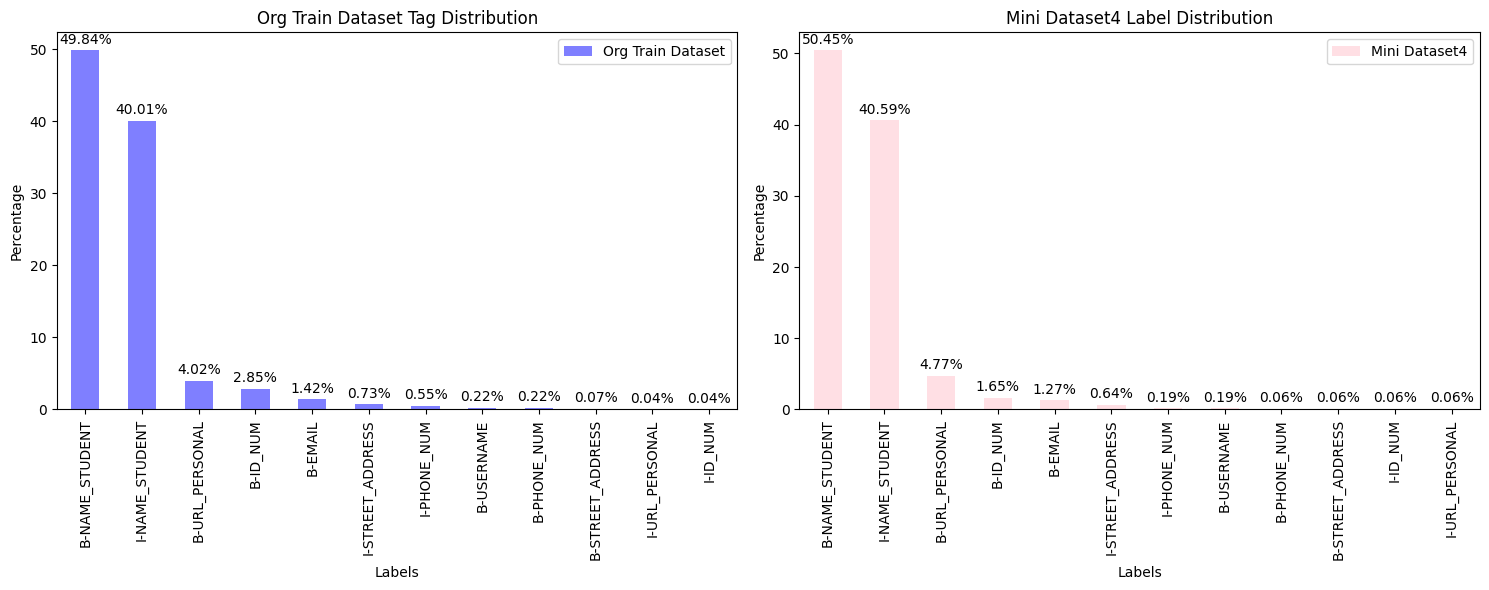

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# org_train veri setini yükleyin (dosya yolu doğru belirtilmelidir)
org_train = json.load(open('/kaggle/input/pii-detection-removal-from-educational-data/train.json'))

# org_train veri setini DataFrame'e dönüştürün
org_train_df = pd.DataFrame(org_train)

# Mini dataset için O etiketi hariç diğer etiketlerin dağılımını hesaplayın
mini_labels = mini_dataset4['labels'].explode()
mini_labels = mini_labels[mini_labels != 'O']
mini_label_distribution = mini_labels.value_counts(normalize=True) * 100

# org_train veri seti için O etiketi hariç diğer etiketlerin dağılımını hesaplayın
org_labels = org_train_df['labels'].explode()
org_labels = org_labels[org_labels != 'O']
org_label_distribution = org_labels.value_counts(normalize=True) * 100

# Grafikleri oluşturun
plt.figure(figsize=(15, 6))

# Sütun grafik oluşturun
plt.subplot(1, 2, 1)
org_label_distribution.plot(kind='bar', color='blue', alpha=0.5, label='Org Train Dataset')
for i in range(len(org_label_distribution)):
    plt.text(i, org_label_distribution[i] + 0.5, f"{org_label_distribution[i]:.2f}%", ha='center', va='bottom')
plt.title('Org Train Dataset Tag Distribution')
plt.xlabel('Labels')
plt.ylabel('Percentage')
plt.legend()

# Sütun grafik oluşturun
plt.subplot(1, 2, 2)
mini_label_distribution.plot(kind='bar', color='pink', alpha=0.5, label='Mini Dataset4')
for i in range(len(mini_label_distribution)):
    plt.text(i, mini_label_distribution[i] + 0.5, f"{mini_label_distribution[i]:.2f}%", ha='center', va='bottom')
plt.title('Mini Dataset4 Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Percentage')
plt.legend()

# Grafikleri gösterin
plt.tight_layout()
plt.show()


**Thank you!**